In [1]:
def set_paths():
    import os
    import sys

    USECASES_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "repositorios", "use-cases")
    if USECASES_SRC not in sys.path:
        sys.path.append(USECASES_SRC)




In [2]:
set_paths()

from churn_nrt.src.utils.spark_session import get_spark_session

In [3]:
sc, spark, sql_context = get_spark_session(app_name="volume_churn")

## Cruzo con clientes en riesgo del modelo general de churn: churners observados en enero

Leo predicciones del modelo general de churn con la foto de 20191231 y etiqueto con las portabilidades de enero

In [4]:
from pyspark.sql.functions import split, col,lit

In [91]:
pred_df = spark\
.read\
.parquet('/data/attributes/vf_es/model_outputs/model_scores/model_name=churn_mobile/year=2019/month=12/day=31')\
.select('msisdn', 'scoring', 'extra_info')\
.withColumn('decil', split(split(col('extra_info'), ';').getItem(0), '=').getItem(1))\
.withColumn('flag_propension',split(split(col('extra_info'), ';').getItem(1), '=').getItem(1))

from churn_nrt.src.data.sopos_dxs import MobPort

port_df = MobPort(spark, churn_window=30)\
.get_module('20191231', save=False, save_others=False, force_gen=True)\
.select("msisdn", "label_mob","target_operator")\
.withColumnRenamed('label_mob', 'churn')


churn_df = pred_df.join(port_df, ['msisdn'], 'left').na.fill({'churn': 0})

[DataTemplate] __init__ | module name = mob_port/30 | path = /data/udf/vf_es/churn_nrt/mob_port/30 | verbose = True
[DataTemplate] get_module | module mob_port/30 - for closing_day=20191231 save=False save_others=False force_gen=True
[DataTemplate] get_module | args: () | kwargs: {}
[MobPort] check_valid_params | Params ok
[DataTemplate] get_module | Module will be generated since force_gen parameter was set to True. An existing module in path will be ignored
[MobPort] check_valid_params | Params ok
[Info get_mobile_portout_requests] - Port-out requests for mobile services during period 20191231-20200130: 171252
[DataTemplate] get_module | module 'mob_port/30' | Elapsed time in build_module function: 0.977582466602 minutes
[DataTemplate] get_module | module 'mob_port/30' | Module will not be saved (save=False and is_default_module()=True)


Leo modelo afinidad

In [92]:
afin_df=spark.read.load('/data/attributes/vf_es/model_outputs/model_scores/model_name=churn_competitor/year=2019/month=12/day=31')

In [23]:
afin_df.limit(5).toPandas()

,executed_at,model_executed_at,predict_closing_date,msisdn,client_id,nif,model_output,scoring,prediction,extra_info,time
0,2020-07-07 13:04:14,2020-07-07 13:04:14,20200131,552120296479,,,0.25491486008737196;0.2596381207453341;0.27925...,,orange,,130414
1,2020-07-07 13:04:14,2020-07-07 13:04:14,20200131,600004947,,,0.29653797015072403;0.213096687427821;0.258195...,,masmovil,,130414
2,2020-07-07 13:04:14,2020-07-07 13:04:14,20200131,600011551,,,0.20887136118102909;0.35189399011993144;0.2526...,,movistar,,130414
3,2020-07-07 13:04:14,2020-07-07 13:04:14,20200131,600015671,,,0.35041421732247857;0.16119260461887433;0.2097...,,masmovil,,130414
4,2020-07-07 13:04:14,2020-07-07 13:04:14,20200131,600030544,,,0.21460262338337302;0.24819544823012735;0.1892...,,others,,130414


In [93]:
afin_df=afin_df.select('msisdn','prediction')

In [26]:
#in churn but not in new afin base

from pyspark.sql.functions import isnull, lit, col, when
churn_df.join(afin_df.withColumn('tmp',lit(1)),
                               ['msisdn'],'left').filter(isnull(col('tmp'))).count() 

1332

In [ ]:
#Agrupo portabilidades de others

In [94]:
churn_df2=churn_df.withColumn('target_operator',when(
    (col('target_operator')=='euskaltel')
    | (col('target_operator')=='telecable')
    | (col('target_operator')=='r')
    | (col('target_operator')=='others'),'others')
    .otherwise(col('target_operator')))

In [95]:
churn_df=churn_df2.select('msisdn','decil','flag_propension','target_operator','churn')

In [ ]:
#Me quedo con churners para evaluar mi modelo

In [96]:
churn_df_churners=churn_df.filter(col('churn')==1)

In [30]:
churn_df_churners.groupby('target_operator').count().show()

+---------------+-----+
|target_operator|count|
+---------------+-----+
|         orange|14341|
|       masmovil|22652|
|       movistar|20940|
|         others|21294|
+---------------+-----+



In [31]:
#Uno con modelo de afinidad

In [97]:
cruce_afin_churn=churn_df_churners.drop('churn').join(afin_df,on='msisdn',how='inner')

In [33]:
cruce_afin_churn.groupby('target_operator').count().show()

+---------------+-----+
|target_operator|count|
+---------------+-----+
|         orange|14339|
|       masmovil|22651|
|       movistar|20933|
|         others|21286|
+---------------+-----+



Extraigo clientes en riesgo del modelo general de churn

In [98]:
cruce_afin_churn.count()

79406

In [34]:
churn_risk_afin=cruce_afin_churn.filter(col('flag_propension')==1)

In [89]:
churn_risk_afin.count()

44217

In [36]:
from pyspark.sql.types import IntegerType

churn_risk_afin=churn_risk_afin.withColumn('decil',col('decil').cast(IntegerType()))

## Multiclass report

In [42]:
#Read predictions


pred_test=spark.read.load('/data/udf/vf_es/churn/churn_competitor_model/v2/multiclase/pred_20200414_evaluation')

In [43]:
pred_test.limit(5).toPandas()

,msisdn,prob_array,prediction,label,prediction_multilabel,label_multilabel,certainity_1,certainity_2,acierto_multilabel
0,678497640,"[0.301068957226, 0.213565628734, 0.27013913708...",1.0,4,"[1.0, 3.0]",[4.0],0.030930,1.375278,0
1,687581520,"[0.247043684178, 0.324094755923, 0.22933375660...",2.0,4,"[2.0, 1.0]",[4.0],0.077051,1.369889,0
2,636095502,"[0.279715901489, 0.25375269511, 0.27291943941,...",1.0,1,"[1.0, 3.0]",[1.0],0.006796,1.376647,1
3,693487097,"[0.223864826088, 0.257835297869, 0.23597076209...",4.0,4,"[4.0, 2.0]",[4.0],0.024494,1.382350,1
4,648669563,"[0.20835404162, 0.231035166528, 0.191444783331...",4.0,4,"[4.0, 2.0]",[4.0],0.138131,1.349681,1


In [189]:
from pyspark.sql.functions import when

pred = pred_test.withColumn("label",
              when(pred_test["label"] == 1, 'masmov').otherwise(
                when(pred_test["label"] == 2, 'mov').otherwise(
                    when(pred_test["label"] == 3, 'or').otherwise(
                        when(pred_test["label"] == 4, 'other').otherwise(0)))))
                            

In [190]:
pred = pred.withColumn("prediction",
              when(pred["prediction"] == 1, 'masmov').otherwise(
                when(pred["prediction"] == 2, 'mov').otherwise(
                    when(pred["prediction"] == 3, 'or').otherwise(
                        when(pred["prediction"] == 4, 'other').otherwise(0)))))
                            

In [41]:
pred=cruce_afin_churn

In [77]:
pred=churn_risk_afin.filter(col('decil')>9)

In [78]:
pred=pred.toPandas()

In [79]:
import pandas as pd
confusion_matrix = pd.crosstab(pred['target_operator'], pred['prediction'], rownames=['target_operator'], colnames=['prediction'])
print(confusion_matrix)

prediction       masmovil  movistar  orange  others
target_operator                                    
masmovil             1084       864     354     834
movistar              378      1689     236     504
orange                348       483     303     393
others                585       855     253    1388


In [80]:
from sklearn.metrics import classification_report
print(classification_report(pred['target_operator'], pred['prediction']))

              precision    recall  f1-score   support

    masmovil       0.45      0.35      0.39      3136
    movistar       0.43      0.60      0.50      2807
      orange       0.26      0.20      0.23      1527
      others       0.45      0.45      0.45      3081

   micro avg       0.42      0.42      0.42     10551
   macro avg       0.40      0.40      0.39     10551
weighted avg       0.42      0.42      0.41     10551



# Obtener cuánto churn capturamos

In [86]:
pred_df = spark\
.read\
.parquet('/data/attributes/vf_es/model_outputs/model_scores/model_name=churn_mobile/year=2020/month=1/day=31')\
.select('msisdn', 'scoring', 'extra_info')\
.withColumn('decil', split(split(col('extra_info'), ';').getItem(0), '=').getItem(1))


from churn_nrt.src.data.sopos_dxs import MobPort
port_df = MobPort(spark, churn_window=30)\
.get_module('20200131', save=False, save_others=False, force_gen=True)\
.select("msisdn", "label_mob")\
.withColumnRenamed('label_mob', 'label')


lab30_pred_df = pred_df.join(port_df, ['msisdn'], 'left').na.fill({'label': 0})



[DataTemplate] __init__ | module name = mob_port/30 | path = /data/udf/vf_es/churn_nrt/mob_port/30 | verbose = True
[DataTemplate] get_module | module mob_port/30 - for closing_day=20200131 save=False save_others=False force_gen=True
[DataTemplate] get_module | args: () | kwargs: {}
[MobPort] check_valid_params | Params ok
[DataTemplate] get_module | Module will be generated since force_gen parameter was set to True. An existing module in path will be ignored
[MobPort] check_valid_params | Params ok
[Info get_mobile_portout_requests] - Port-out requests for mobile services during period 20200131-20200301: 169463
[DataTemplate] get_module | module 'mob_port/30' | Elapsed time in build_module function: 0.408583601316 minutes
[DataTemplate] get_module | module 'mob_port/30' | Module will not be saved (save=False and is_default_module()=True)


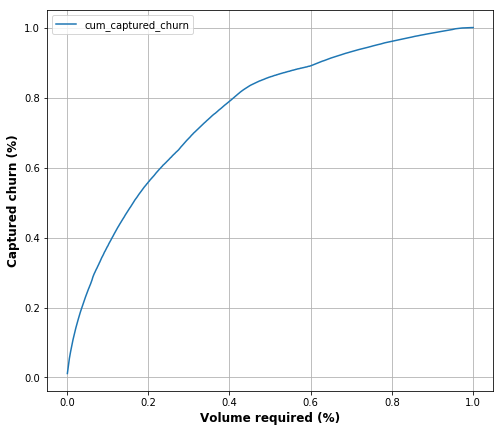

In [87]:
import matplotlib.pyplot as plt


from churn_nrt.src.projects_utils.models.modeler import get_cumulative_churn_rate_fix_step
lift_mob_df = get_cumulative_churn_rate_fix_step(spark, lab30_pred_df, step_ = 5000, ord_col ="scoring", label_col ="label", verbose = False, noise = 0.000001)
capt_mob_pd = lift_mob_df.select('cum_volume_for_capture', 'cum_captured_churn').toPandas()
fig,ax = plt.subplots(figsize=(8,7))
font={'fontsize':12, 'fontweight': 'bold'}
ax.plot(capt_mob_pd.cum_volume_for_capture, capt_mob_pd.cum_captured_churn)
ax.set_xlabel("Volume required (%)", fontdict = font)
ax.set_ylabel("Captured churn (%)", fontdict = font)
ax.legend(loc='best')
ax.grid(True)

## Ver cuántos churners se pierden tras aplicar cada filtro

Cojo ids sin filtros y le añado portabilidades. Después aplico función funnel para ver cuántos churners se pierden tras filtros

In [4]:
from churn_nrt.src.data_utils.ids_utils import get_ids
from pyspark.sql.functions import col

In [5]:
df_ids_train = get_ids(spark, '20191231').where(col('serv_rgu') == 'mobile').dropDuplicates(['msisdn'])

/data/udf/vf_es/amdocs_inf_dataset/amdocs_ids_service_level/year=2019/month=12/day=31


In [6]:
from churn_nrt.src.data.sopos_dxs import MobPort

port_df = MobPort(spark, churn_window=30)\
.get_module('20191231', save=False, save_others=False, force_gen=True)\
.select("msisdn", "label_mob")\
.withColumnRenamed('label_mob', 'churn')

pop_df = df_ids_train.join(port_df, ['msisdn'], 'left').na.fill({'churn': 0})

[DataTemplate] __init__ | module name = mob_port/30 | path = /data/udf/vf_es/churn_nrt/mob_port/30 | verbose = True
[DataTemplate] get_module | module mob_port/30 - for closing_day=20191231 save=False save_others=False force_gen=True
[DataTemplate] get_module | args: () | kwargs: {}
[MobPort] check_valid_params | Params ok
[DataTemplate] get_module | Module will be generated since force_gen parameter was set to True. An existing module in path will be ignored
[MobPort] check_valid_params | Params ok
[Info get_mobile_portout_requests] - Port-out requests for mobile services during period 20191231-20200130: 171252
[DataTemplate] get_module | module 'mob_port/30' | Elapsed time in build_module function: 0.802100217342 minutes
[DataTemplate] get_module | module 'mob_port/30' | Module will not be saved (save=False and is_default_module()=True)


In [10]:
len(pop_df.columns)

5278

In [7]:
def get_funnel(spark, pop_df, date_, n_cycles=12, verbose = False):
    

    from churn_nrt.src.utils.date_functions import move_date_n_cycles, get_diff_days
    date_prev = move_date_n_cycles(date_, -n_cycles)
    diff_days = get_diff_days(date_prev, date_, format_date="%Y%m%d")
    pop_df.cache()
    print '[Info] Initial - Initial volume: ' + str(pop_df.count()) + ' - Initial number of msisdn: ' + str(pop_df.select('msisdn').distinct().count()) + ' - Initial number of NIFs: ' + str(pop_df.select('nif_cliente').distinct().count()) + ' - Initial number of churners: ' +  str(pop_df.filter(col('churn')==1).count())
    #if filter_recent:
    from churn_nrt.src.data_utils.base_filters import get_non_recent_customers_filter
    df_ids_rec = get_non_recent_customers_filter(spark, date_, diff_days, level='nif', verbose = False)
    filt_pop_df = pop_df.join(df_ids_rec.select('nif_cliente'), ['nif_cliente'], 'inner')\
    .select('msisdn', 'num_cliente', 'nif_cliente','churn')
    filt_pop_df.cache()
    print '[Info] Recent customers - Volume: ' + str(filt_pop_df.count()) + ' - Number of msisdn: ' + str(filt_pop_df.select('msisdn').distinct().count()) + ' - Number of NIFs: ' + str(filt_pop_df.select('nif_cliente').distinct().count()) + ' - Churners: ' +  str(filt_pop_df.filter(col('churn')==1).count())
    
    #if filter_disc:
    from churn_nrt.src.data_utils.base_filters import get_disconnection_process_filter
    df_ids_disc = get_disconnection_process_filter(spark, date_, diff_days, verbose=verbose, level="nif_cliente")
    filt_pop_df = filt_pop_df.join(df_ids_disc.select('nif_cliente'), ['nif_cliente'], 'inner')
    filt_pop_df.cache()
    print '[Info] DX customers - Volume: ' + str(filt_pop_df.count()) + ' - Number of msisdn: ' + str(filt_pop_df.select('msisdn').distinct().count()) + ' - Number of NIFs: ' + str(filt_pop_df.select('nif_cliente').distinct().count())  + ' - Churners: ' +  str(filt_pop_df.filter(col('churn')==1).count())
   
    # if filter_ord:
    filt_pop_df = filt_pop_df.join(pop_df.select('nif_cliente', "Ord_sla_has_forbidden_orders_last90"), ['nif_cliente'], 'inner').where(~(col("Ord_sla_has_forbidden_orders_last90") > 0))
    filt_pop_df.cache()
    print '[Info] Orders - Volume: ' + str(filt_pop_df.count()) + ' - Number of msisdn: ' + str(filt_pop_df.select('msisdn').distinct().count()) + ' - Number of NIFs: ' + str(filt_pop_df.select('nif_cliente').distinct().count()) + ' - Churners: ' +  str(filt_pop_df.filter(col('churn')==1).count())
    
    # if filter_cc:
    filt_pop_df = filt_pop_df.join(pop_df.select('nif_cliente', "CCC_CHURN_CANCELLATIONS_w8"), ['nif_cliente'], 'inner').where(~(col("CCC_CHURN_CANCELLATIONS_w8") > 0))
    filt_pop_df.cache()
    print '[Info] Churn call - Volume: ' + str(filt_pop_df.count()) + ' - Number of msisdn: ' + str(filt_pop_df.select('msisdn').distinct().count()) + ' - Number of NIFs: ' + str(filt_pop_df.select('nif_cliente').distinct().count()) + ' - Churners: ' +  str(filt_pop_df.filter(col('churn')==1).count())
    
    return 1

In [8]:
get_funnel(spark, pop_df, '20191231', n_cycles=12, verbose = False)

KeyboardInterrupt: 

In [ ]:
df_ids_train2 = get_ids(spark, '20200131').where(col('serv_rgu') == 'mobile').dropDuplicates(['msisdn']).select(
            'msisdn')

In [ ]:
port_df2 = MobPort(spark, churn_window=30)\
.get_module('20200131', save=False, save_others=False, force_gen=True)\
.select("msisdn", "label_mob")\
.withColumnRenamed('label_mob', 'churn')

pop_df2 = df_ids_train2.join(port_df2, ['msisdn'], 'left').na.fill({'churn': 0})

In [ ]:
get_funnel(spark, pop_df2, '20200131', n_cycles=12, verbose = False)